## Relevant peaks extraction
#### Source papers:
1. A Real-Time QRS Detection Algorithm
2. Reliable P wave detection in pathological ECG signals
3. Application of the phasor transform for automatic delineation of single-lead ECG fiducial points

In [1]:
import copy
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# Extract data from files

# Samples from the original data to load
SAMPLE_NUM = 30000

record = wfdb.rdrecord('src/mitdb/100', sampto = SAMPLE_NUM)
annotation = wfdb.rdann('src/mitdb/100', 'atr', sampto = SAMPLE_NUM)

#wfdb.plot_wfdb(record=record, annotation=annotation,
#               title='Record 100 from MIT-BIH Arrhythmia Database',
#               time_units='seconds')
#display(record.__dict__)
#display(annotation.__dict__)


In [3]:
# Sampling frequency
FREQ_SAMPLE = 360

# Extract ECG data array
v_data = record.p_signal
v_data = v_data[:,0]

# Define time array (Fs:360Hz)
v_time = np.arange(0, v_data.size, 1, dtype=int)
v_time = np.round(v_time/FREQ_SAMPLE, 3)

# Extract annotations array
v_ann = np.zeros(shape=(v_data.size,1), dtype=str)
for i in range(len(annotation.sample)):
    v_ann[(annotation.sample)[i]] = annotation.symbol[i]


In [4]:
# Zeros array for x-axis

axis_x = np.zeros_like(v_data)

### QRS Detection
Following paper [1]

In [5]:
# Signal filtering

# Apply lowpass filter
# Difference equation:
# y(nT) = 2y(nT-T) - y(nT-2T) + x(nT) - 2x(nT-5T) + x(nT-10T)

x = np.ones_like(v_data)*v_data
for i in range(0,15):
    x[i] = 0
y = np.zeros_like(v_data)
for i in range(12, len(y)):
    y[i] = 2*y[i-1] - y[i-2] + x[i] - 2*x[i-5] + x[i-10]
v_data_lp = np.copy(y)

# Apply highpass filter to obtain bandpass
# Difference equation:
# y(nT) = -x(nT)/32 + x(nT-16T) - x(nT-17T) + x(nT-32T)/32 + y(nT-1T)

x = np.copy(v_data_lp)
y = np.zeros_like(v_data_lp)
for i in range(35, len(y)):
    y[i] = -x[i]/32 + x[i-16] - x[i-17] + x[i-32]/32 + y[i-1]
v_data_bp = np.copy(y)

# Derivative filter
# Difference equation:
# y(nT) = 0.1(-x(nT-2T)) - 2x(nT-T) + 2x(nT+T) + x(nT+2T))

x = np.copy(v_data_bp)
y = np.zeros_like(v_data_bp)
for i in range(2, len(y)-2):
    y[i] = 0.1*(-x[i-2] - 2*x[i-1] + 2*x[i+1] + x[i+2])
v_data_der = np.copy(y)

# Squaring filter
# y(nT) = (x(nT)^2)

v_data_sq = v_data_der*v_data_der

In [6]:
# Moving average

# Window size for moving averages
WINDOW_TIME = 0.120 #ms
WINDOW_NUM = int(FREQ_SAMPLE*WINDOW_TIME)

v_data_avg = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

tmp_avg = moving_average(v_data_sq, WINDOW_NUM)
v_data_avg = np.pad(tmp_avg, (WINDOW_NUM-1,0), 'constant', constant_values=(tmp_avg[0],0))

In [7]:
# Find R peaks

DELAY = 20              # Delay between integrated signal and filtered signal

signal_level_int = 0    # Running estimate of signal level for integrated signal
noise_level_int = 0     # Running estimate of noise level for integrated signal
signal_level_fil = 0    # Running estimate of signal level for filtered signal
noise_level_fil = 0     # Running estimate of noise level for filtered signal

threshold_int = 0.2     # Threshold for immediate detection, integrated signal
threshold_fil = 0.1     # Threshold for second check, filtered signal

v_peaks_data_raw = np.zeros_like(v_data_avg)
v_peaks_time_raw = np.zeros_like(v_data_avg)
v_peaks_data = np.zeros_like(v_data_avg)
v_peaks_time = np.zeros_like(v_data_avg)
j = 0

# Thresholds and estimates for plotting
v_thr_int = np.zeros_like(v_data_avg)
v_thr_fil = np.zeros_like(v_data_avg)
v_sig_lvl_int = np.zeros_like(v_data_avg)
v_sig_lvl_fil = np.zeros_like(v_data_avg)
v_noi_lvl_int = np.zeros_like(v_data_avg)
v_noi_lvl_fil = np.zeros_like(v_data_avg)

for i in range(len(v_data_avg)):
    # Check for local maximum
    if ((v_data_avg[i] > v_data_avg[i-1]) and (v_data_avg[i] > v_data_avg[i+1])):
        # Check if maximum is higher/lower than first threshold
        if (v_data_avg[i] < threshold_int):
            # Wrong peak detected
            # Update noise level
            noise_level_int = 0.125*v_data_avg[i] + 0.875*noise_level_int
        elif (v_data_avg[i] >= threshold_int):
            # Potential peak found
            # Check against filtered signal
            if (v_data_bp[i-DELAY] < threshold_fil):
                # Peak discarded
                # Update noise level
                noise_level_fil = 0.125*v_data_avg[i] + 0.875*noise_level_fil
            elif (v_data_bp[i-DELAY] >= threshold_fil):
                # Update signal level
                signal_level_int = 0.125*v_data_avg[i] + 0.875*signal_level_int
                signal_level_fil = 0.125*v_data_avg[i] + 0.875*signal_level_fil
                # Record peak
                v_peaks_data_raw[i] = v_data_avg[i]
                v_peaks_time_raw[i] = v_time[i]
                #v_peaks_data[j] = v_data_avg[i]
                #v_peaks_time[j] = v_time[i]
                #j += 1
        # Update all thresholds
        threshold_int = noise_level_int + 0.25*(signal_level_int - noise_level_int)
        threshold_fil = noise_level_fil + 0.25*(signal_level_fil - noise_level_fil)
    # Store thresholds for plotting
    v_thr_int[i] = threshold_int
    v_thr_fil[i] = threshold_fil
    # Store signal and noise levels for plotting
    v_sig_lvl_int[i] = signal_level_int
    v_sig_lvl_fil[i] = signal_level_fil
    v_noi_lvl_int[i] = noise_level_int
    v_noi_lvl_fil[i] = noise_level_fil

# Delete empty data from peaks arrays
v_peaks_data = v_peaks_data_raw[v_peaks_time_raw != 0]
v_peaks_time = v_peaks_time_raw[v_peaks_time_raw != 0]

# Align peaks with bandpass signal
v_peaks_time_bp = np.zeros_like(v_peaks_time)
v_peaks_data_bp = np.zeros_like(v_peaks_data)
for i in range(len(v_peaks_time)):
    v_peaks_data_bp[i] = v_peaks_data[i]*5
    v_peaks_time_bp[i] = v_peaks_time[i] - (DELAY/FREQ_SAMPLE)


In [8]:
# Calculate RR times: time between two R peaks

R_prev = 0
RR_time = 0
v_RR_time = np.zeros_like(v_peaks_data_raw)

for i in range(len(v_peaks_data_raw)):
    if (v_peaks_data_raw[i] != 0):
        RR_time = v_peaks_time_raw[i] - R_prev
        R_prev = v_peaks_time_raw[i]
    if (i-DELAY>0):
        v_RR_time[i-DELAY] = RR_time

    #print("i: " + str(i) + " RR: " + str(RR_time) + " R_prev: " + str(R_prev))



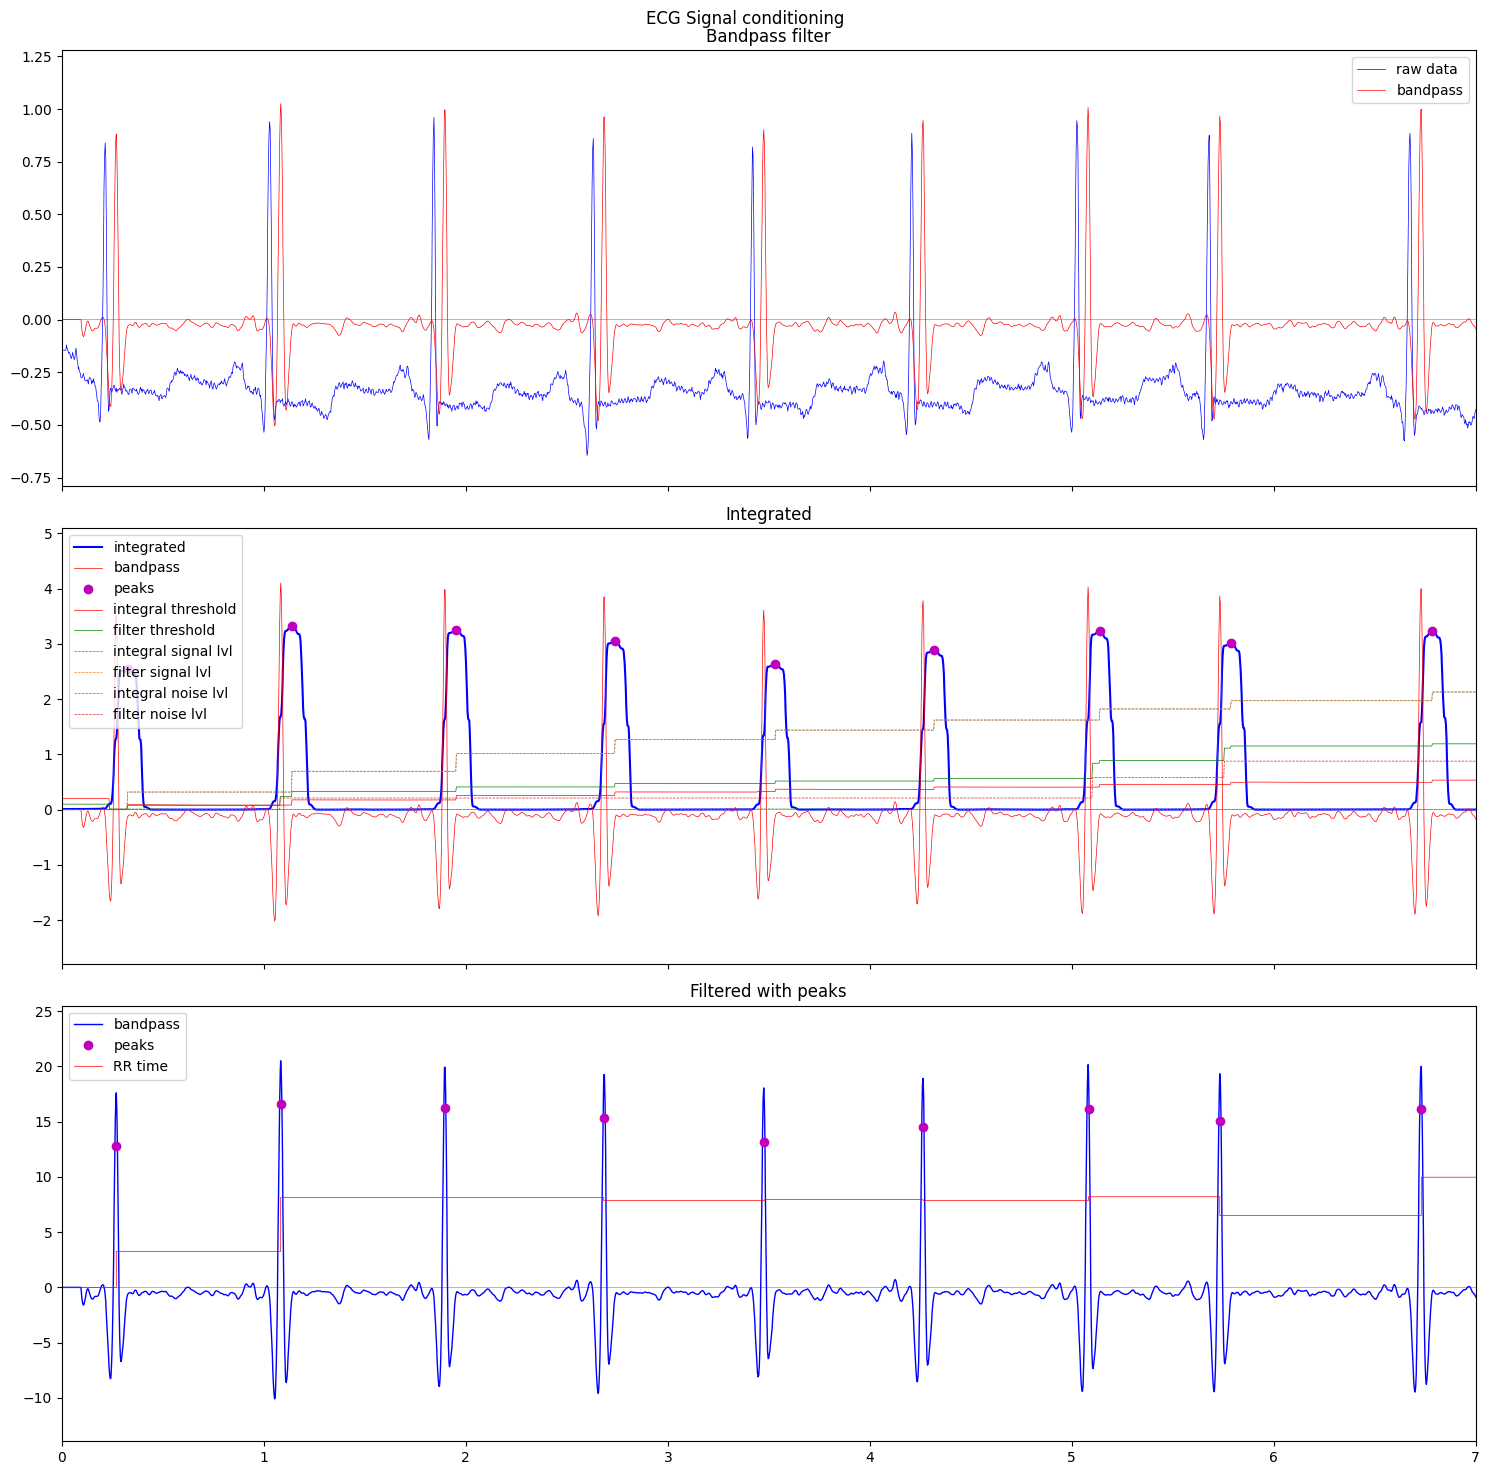

In [9]:
# Plotting window
X_MIN = 0.0
X_MAX = 7.0

n = 0
# Create plots
fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(15, 15)
fig.suptitle("ECG Signal conditioning")
axs[n].set_xlim(X_MIN, X_MAX)

# First plot
axs[n].title.set_text('Bandpass filter')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
axs[n].plot(v_time, v_data_bp/20, 'r', label="bandpass", linewidth=0.5)
#axs[0].plot(v_time, v_data_lp, 'g', label="lowpass", linewidth=0.5)
#axs[0].plot(v_time, v_data_bp, 'r', label="bandpass", linewidth=0.5)
#axs[0].plot(v_time, v_data_hp, 'm', label="highpass", linewidth=0.5)
axs[n].legend()
n += 1

# Plot
axs[n].title.set_text('Integrated')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data_avg, 'b', label="integrated", linewidth=1.5)
axs[n].plot(v_time, v_data_bp/5, 'r', label="bandpass", linewidth=0.5)
axs[n].plot(v_peaks_time, v_peaks_data, 'mo', label="peaks", linewidth=1)
axs[n].plot(v_time, v_thr_int, 'r-', label="integral threshold", linewidth=0.5)
axs[n].plot(v_time, v_thr_fil, 'g-', label="filter threshold", linewidth=0.5)
axs[n].plot(v_time, v_sig_lvl_int, '--', label="integral signal lvl", linewidth=0.5)
axs[n].plot(v_time, v_sig_lvl_fil, '--', label="filter signal lvl", linewidth=0.5)
axs[n].plot(v_time, v_noi_lvl_int, '--', label="integral noise lvl", linewidth=0.5)
axs[n].plot(v_time, v_noi_lvl_fil, '--', label="filter noise lvl", linewidth=0.5)
axs[n].legend()
n += 1


# Plot
axs[n].title.set_text('Filtered with peaks')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data_bp, 'b', label="bandpass", linewidth=1)
axs[n].plot(v_peaks_time_bp, v_peaks_data_bp, 'mo', label="peaks", linewidth=1)
axs[n].plot(v_time, v_RR_time*10, 'r-', label="RR time", linewidth=0.5, drawstyle='steps-post')
axs[n].legend()
n += 1


plt.tight_layout()
plt.show()